<a href="https://colab.research.google.com/github/Z0rrill0/VisionArtificial/blob/main/EVA3-REV-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving steam-200k.csv to steam-200k (6).csv
MAE (Error Absoluto Medio): 61.45851699899725
MSE (Error Cuadrático Medio): 50582.786928062305
R² (Coeficiente de Determinación): 0.0534588506289525
El juego proyectado con mayor número de horas jugadas en los próximos 2 años es: Dota 2


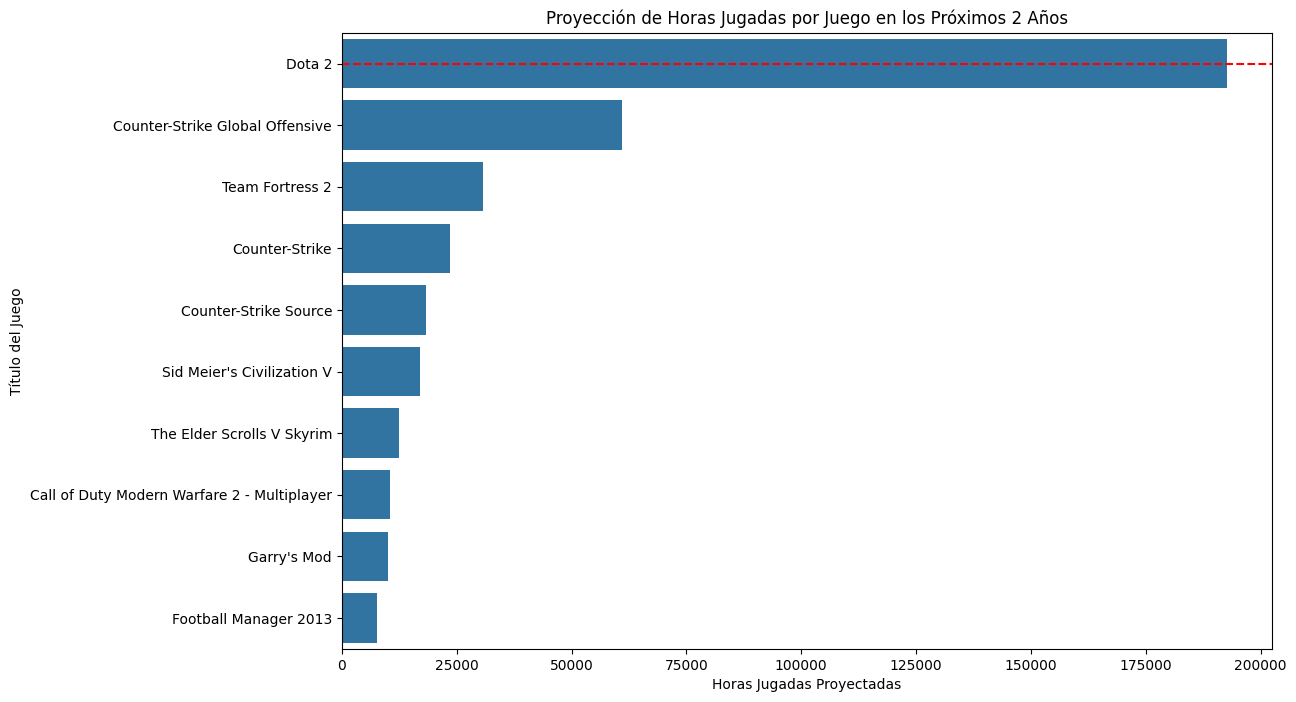

In [8]:
# Importación de bibliotecas necesarias
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Subir y cargar el archivo
load = files.upload()  # Solo funciona en Google Colab
data = pd.read_csv('steam-200k.csv', header=None)  # Cargar sin encabezado

# Asignar nombres de columnas manualmente
data.columns = ['user-id', 'game-title', 'behavior-name', 'value', 'other']

# Filtrar solo el comportamiento de 'play' (ya que queremos predecir horas jugadas)
data_play = data[data['behavior-name'] == 'play'].copy()

# Codificar variables categóricas
data = pd.get_dummies(data_play, columns=['game-title'], drop_first=False)  # Incluimos todas las columnas de juegos

# Convertir el 'user-id' a numérico (opcional si se quiere agregar como una característica)
data['user-id'] = data['user-id'].astype('int64')

# Definir las características (X) y la variable objetivo (y)
X = data.drop(['value', 'behavior-name', 'other'], axis=1)  # Características
y = data['value']  # Variable objetivo: horas jugadas

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir métricas de evaluación
print(f'MAE (Error Absoluto Medio): {mae}')
print(f'MSE (Error Cuadrático Medio): {mse}')
print(f'R² (Coeficiente de Determinación): {r2}')

# Realizar proyecciones para los próximos 2 años
proyecciones_futuras = model.predict(X_test)

# Crear un DataFrame para asociar las proyecciones con los títulos de juegos
X_test['predicciones'] = proyecciones_futuras
columnas_juegos = [col for col in X_test.columns if 'game-title_' in col]
proyecciones_por_juego = X_test[columnas_juegos].multiply(X_test['predicciones'], axis="index")

# Sumar las horas proyectadas para cada juego
horas_por_juego = proyecciones_por_juego.sum().sort_values(ascending=False)

# Identificar el juego con mayor proyección de horas jugadas
juego_mas_jugado = horas_por_juego.idxmax().replace("game-title_", "")
print(f"El juego proyectado con mayor número de horas jugadas en los próximos 2 años es: {juego_mas_jugado}")

# Visualización de los juegos más jugados proyectados en un gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x=horas_por_juego.head(10).values, y=horas_por_juego.head(10).index.str.replace("game-title_", ""))
plt.xlabel("Horas Jugadas Proyectadas")
plt.ylabel("Título del Juego")
plt.title("Proyección de Horas Jugadas por Juego en los Próximos 2 Años")
plt.axhline(y=0, color="r", linestyle="--")
plt.show()